In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2023-07-19 12:08:13.657839: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 12:08:14.213525: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 12:08:14.218603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 12:08:16.171079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the Q-Network model
def create_q_network(input_shape, action_space):
    model = Sequential(
        [
            tf.keras.Input(shape=input_shape),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(action_space, activation='linear')
        ]
    )
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

In [3]:
class ENV():
    def __init__(self):
        self.steps = 0
        self.env_col = 11
        self.env_row = 11
        self.state = (5, 5)
        self.action_space = 4
        self.reward = 0
        self.done = False
        self.goal = (1, 1)

    def reset(self):
        self.state = np.random.randint(0, min(self.env_col, self.env_row), size=2)
        self.reward = 0
        self.done = False
        self.steps = 0
        return self.state
    
    def step(self, action):
        self.steps += 1
        if action == 0: # up
            self.state = (self.state[0], self.state[1] + 1)
        elif action == 1: # down
            self.state = (self.state[0], self.state[1] - 1)
        elif action == 2: # left
            self.state = (self.state[0] - 1, self.state[1])
        elif action == 3: # right
            self.state = (self.state[0] + 1, self.state[1])
        else:
            raise ValueError("Invalid action")
        if self.state == self.goal:
            self.reward = 100
            self.done = True
        elif self.state[0] < 0 or self.state[0] >= self.env_col or self.state[1] < 0 or self.state[1] >= self.env_row:
            self.reward = -100
            self.done = True
        elif self.steps >= 50:
            self.reward = -100
            self.done = True
        else:
            self.reward = -1
        return self.state, self.reward, self.done


In [7]:
#Define the DQN agent
class DQNAgent:
    def __init__(self, state_shape, action_space):
        self.state_shape = state_shape
        self.action_space = action_space
        self.memory = []
        self.gamma = 0.95  # Discount factor
        self.epsilon = 0.9  # Exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.model = create_q_network(state_shape, action_space)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space)
        # print("state in action: ",state)
        state = np.reshape(state, self.state_shape)
        print("prinintg rereshaped state: ", state)
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        print("Predicting")
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        # Debug
        # print(self.memory)
        # batch = np.random.choice(self.memory, batch_size, replace=False)
        batch_ch = np.random.choice(len(self.memory), batch_size, replace=False)
        batch = [self.memory[i] for i in batch_ch]
        for state, action, reward, next_state, done in batch:
            state = np.reshape(state, self.state_shape)
            next_state = np.reshape(next_state, self.state_shape)
            target = reward
            if not done:
                # print(next_state.shape)
                next_state = tf.convert_to_tensor(next_state)
                next_state = tf.expand_dims(next_state, 0)
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            # print(state.shape)
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)
            print("Predicting")
            target_f = self.model.predict(state)
            target_f[0][action] = target
            # print(state[0], state[1])
            print("Fitting model")
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [8]:
# Initialize the environment and agent
state_shape = (2,)  # Example state shape, adjust according to your actual state representation # Only x and y coordinates
action_space = 4  # Example action space size, adjust according to your actual actions # 4 actions: up, down, left, right
agent = DQNAgent(state_shape, action_space)
env = ENV()

In [10]:
#Training loop
num_episodes = 50  # Set the number of training episodes
batch_size = 32  # Set the batch size for replay
total_reward = []
for episode in range(num_episodes):
    print("Episode: ", episode)
    state = env.reset()
    print("prinintg no shaped: ", state)
    state = np.reshape(state, state_shape)
    done = False
    episode_reward = 0
    while not done:
        print("prinintg reshaped state: ", state)
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state, state_shape)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    total_reward.append(episode_reward)

Episode:  0
prinintg no shaped:  [0 6]
prinintg reshaped state:  [0 6]
prinintg rereshaped state:  [0 6]
Predicting
1/1 [==============================] - 1s 694ms/step
Predicting


1/1 [==============================] - 1s 929ms/step
Fitting model
1/1 [==============================] - 1s 1s/step
Predicting
1/1 [==============================] - 2s 2s/step
Fitting model
Predicting


KeyboardInterrupt: 

In [34]:
# Use the trained agent to control the agent in the environment
state = env.reset()
print("state: ", state)
state = np.reshape(state, state_shape)
done = False
while not done:
    # print("prinintg state: ", state)
    action = agent.act(state)
    next_state, _, done = env.step(action)
    next_state = np.reshape(next_state, state_shape)
    # Take action with the agent in the environment
    state = next_state
    print(state)

state:  [3 4]
Predicting
1/1 [==============================] - 0s 15ms/step
[3 3]
[3 4]
Predicting
1/1 [==============================] - 0s 14ms/step
[3 3]
Predicting
1/1 [==============================] - 0s 16ms/step
[2 3]
Predicting
1/1 [==============================] - 0s 13ms/step
[2 2]
Predicting
1/1 [==============================] - 0s 15ms/step
[1 2]
Predicting
1/1 [==============================] - 0s 15ms/step
[1 1]


In [30]:
# agent.model.save("model_dqn_pt_to_pt_diff_start.h5")

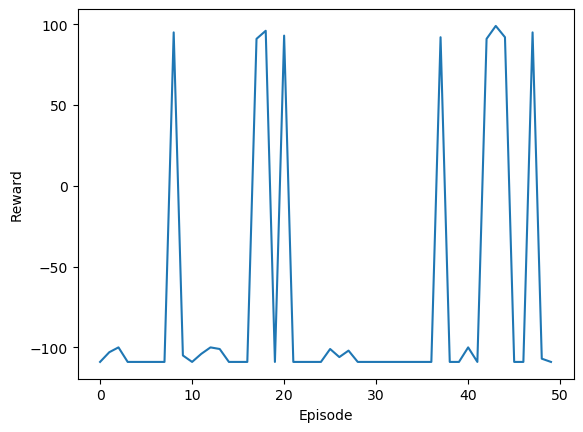

In [31]:
import matplotlib.pyplot as plt
plt.plot(total_reward)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

TESTING THE MODEL 

In [9]:
#Define the DQN agent for TESTING
class DQNAgent_test:
    def __init__(self, state_shape, action_space):
        self.state_shape = state_shape
        self.action_space = action_space
        self.memory = []
        self.gamma = 0.95  # Discount factor
        self.epsilon = 0.9  # Exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.model = load_model('model_dqn_pt_to_pt_diff_start.h5')
        # while testing a different model has to be loaded instead of creating a new dqn model 
        # so i created a new DQNAgent_test clas ony for testing 

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space)
        # print("state in action: ",state)
        state = np.reshape(state, self.state_shape)
        print("prinintg rereshaped state: ", state)
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        print("Predicting")
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        # Debug
        # print(self.memory)
        # batch = np.random.choice(self.memory, batch_size, replace=False)
        batch_ch = np.random.choice(len(self.memory), batch_size, replace=False)
        batch = [self.memory[i] for i in batch_ch]
        for state, action, reward, next_state, done in batch:
            state = np.reshape(state, self.state_shape)
            next_state = np.reshape(next_state, self.state_shape)
            target = reward
            if not done:
                # print(next_state.shape)
                next_state = tf.convert_to_tensor(next_state)
                next_state = tf.expand_dims(next_state, 0)
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            # print(state.shape)
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)
            print("Predicting")
            target_f = self.model.predict(state)
            target_f[0][action] = target
            # print(state[0], state[1])
            print("Fitting model")
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [12]:
# Initialize the environment and agent
state_shape = (2,)  # Example state shape, adjust according to your actual state representation # Only x and y coordinates
action_space = 4  # Example action space size, adjust according to your actual actions # 4 actions: up, down, left, right
agent = DQNAgent_test(2, action_space)
env = ENV()

In [24]:
# Use the trained agent to control the agent in the environment
state = env.reset()
print("state: ", state)
state = np.reshape(state, state_shape)
done = False
while not done:
    # print("prinintg state: ", state)
    action = agent.act(state)
    next_state, _, done = env.step(action)
    next_state = np.reshape(next_state, state_shape)
    # Take action with the agent in the environment
    state = next_state
    print(state)

state:  [10  0]
[11  0]
